## Setup

In [46]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision import datasets
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['figure.facecolor'] = '#ffffff'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset Creation

In [47]:
stats = ((0.5,0.5,0.5), (0.5,0.5,0.5))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [48]:
batch_size = 128

# download CIFAR10 training and test datasets
training_data = datasets.CIFAR10(
   root="data",
   train=True,
   download=True,
   transform=train_tfms
)

test_data = datasets.CIFAR10(
   root="data",
   train=False,
   download=True,
   transform=valid_tfms
)

Files already downloaded and verified
Files already downloaded and verified


In [49]:
# define train and test dataloader
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# access names of the labels
label_names = training_data.classes

# display details about the dataset
print("label_names:", label_names)
print("class label name to index:", training_data.class_to_idx)
print("Shape of training data:", training_data.data.shape )
print("Shape of test data:", test_data.data.shape )

label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class label name to index: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Shape of training data: (50000, 32, 32, 3)
Shape of test data: (10000, 32, 32, 3)


## Visualize

In [50]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
    
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

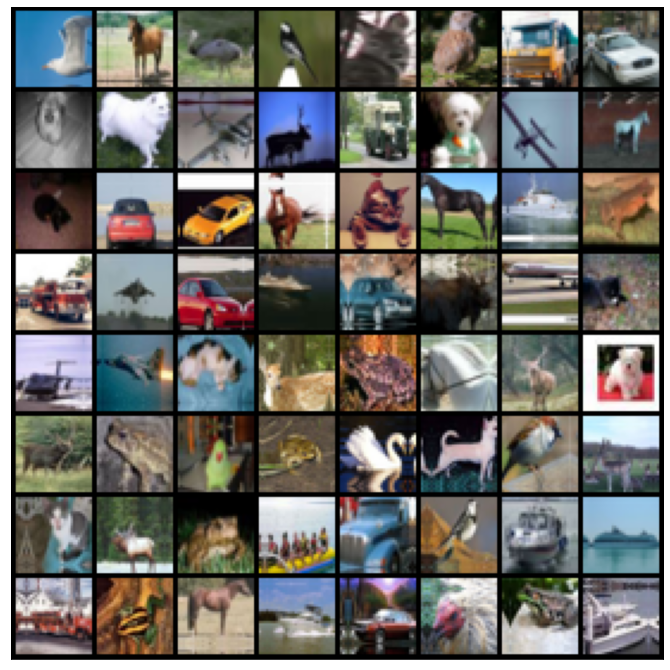

In [51]:
show_batch(trainloader)

## Model

In [52]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        #input 3x32x32
        out = self.conv1(xb)
        #out 64x32x32
        out = self.conv2(out)
        #out 128x16x16
        out = self.res1(out) + out
        #out 128x16x16
        out = self.conv3(out)
        #out 256x8x8
        out = self.conv4(out)
        #out 512x4x4
        out = self.res2(out) + out
        #out 512x4x4
        out = self.classifier(out)
        return out

In [53]:
model = ResNet9(3, 10).to(device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Optim,Loss,Accuracy

In [54]:
#Optmizer and loss function
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                0.001,   #maxlr
                                                epochs=10, 
                                                steps_per_epoch=len(trainloader))

In [55]:
#calculating the size of training and testing images
train_count=training_data.data.shape[0]
test_count=test_data.data.shape[0]
print(train_count,test_count)

50000 10000


## Training

In [56]:
#Model training and saving best model
warnings.filterwarnings("ignore")
num_epochs = 10
best_accuracy=0.0
grad_clip = 0.1
val_loss_history = []
train_loss_history = []
val_acc_history = []
train_acc_history = []

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    loop = tqdm(enumerate(trainloader),total=len(trainloader))
    for i, (images,labels) in loop:
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()

        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()
        schedular.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        loop.set_description(f"Epoch[{epoch}/{num_epochs}]")
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(testloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        test_loss+=loss_function(outputs,labels).cpu().data*images.size(0)
    val_loss = test_loss/test_count
    test_accuracy=test_accuracy/test_count
    print(' Train Loss: '+str(train_loss.item())+' Val Loss: '+str(val_loss.item()) +' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    val_loss_history.append(val_loss.item())
    train_loss_history.append(train_loss.item())
    val_acc_history.append(test_accuracy)
    train_acc_history.append(train_accuracy)
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch[0/10]: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]


 Train Loss: 1.6162530183792114 Val Loss: 1.1378179788589478 Train Accuracy: 0.43894 Test Accuracy: 0.5962


Epoch[1/10]: 100%|██████████| 391/391 [00:37<00:00, 10.37it/s]


 Train Loss: 1.0718622207641602 Val Loss: 0.7920344471931458 Train Accuracy: 0.624 Test Accuracy: 0.7261


Epoch[2/10]: 100%|██████████| 391/391 [00:38<00:00, 10.08it/s]


 Train Loss: 0.8135244250297546 Val Loss: 0.8967897295951843 Train Accuracy: 0.71972 Test Accuracy: 0.701


Epoch[3/10]: 100%|██████████| 391/391 [00:38<00:00, 10.08it/s]


 Train Loss: 0.6627734899520874 Val Loss: 0.6476163864135742 Train Accuracy: 0.7734 Test Accuracy: 0.7768


Epoch[4/10]: 100%|██████████| 391/391 [00:38<00:00, 10.23it/s]


 Train Loss: 0.5520306825637817 Val Loss: 0.5573937296867371 Train Accuracy: 0.8094 Test Accuracy: 0.8097


Epoch[5/10]: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


 Train Loss: 0.4728420376777649 Val Loss: 0.4720218777656555 Train Accuracy: 0.83728 Test Accuracy: 0.8403


Epoch[6/10]: 100%|██████████| 391/391 [00:37<00:00, 10.34it/s]


 Train Loss: 0.3936469554901123 Val Loss: 0.502164900302887 Train Accuracy: 0.86396 Test Accuracy: 0.8339


Epoch[7/10]: 100%|██████████| 391/391 [00:38<00:00, 10.23it/s]


 Train Loss: 0.3151800036430359 Val Loss: 0.33335214853286743 Train Accuracy: 0.89136 Test Accuracy: 0.8863


Epoch[8/10]: 100%|██████████| 391/391 [00:38<00:00, 10.14it/s]


 Train Loss: 0.2517172396183014 Val Loss: 0.28450071811676025 Train Accuracy: 0.91414 Test Accuracy: 0.9023


Epoch[9/10]: 100%|██████████| 391/391 [00:38<00:00, 10.22it/s]


 Train Loss: 0.21060389280319214 Val Loss: 0.2671828269958496 Train Accuracy: 0.92738 Test Accuracy: 0.9103


## Results

In [57]:
def plot_accuracies(train_acc_history,val_acc_history):
    plt.plot(val_acc_history,label="validation")
    plt.plot(train_acc_history,label="train")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend()


def plot_losses(train_loss_history,val_loss_history):
    plt.plot(train_loss_history,label="train")
    plt.plot(val_loss_history,label="validation")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs');

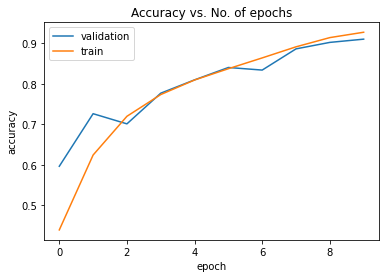

In [58]:
plot_accuracies(train_acc_history,val_acc_history)

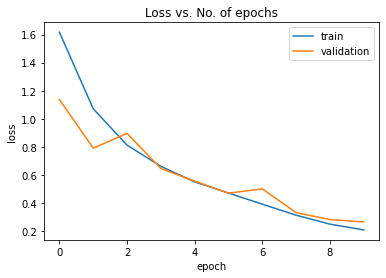

In [59]:
plot_losses(train_loss_history,val_loss_history)